In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fundus-pytorch/val/0/OIA-ODIR-TEST-ONLINE-577.png
/kaggle/input/fundus-pytorch/val/0/REFUGE1-train-211.png
/kaggle/input/fundus-pytorch/val/0/OIA-ODIR-TRAIN-823.png
/kaggle/input/fundus-pytorch/val/0/PAPILA-387.png
/kaggle/input/fundus-pytorch/val/0/OIA-ODIR-TRAIN-2843.png
/kaggle/input/fundus-pytorch/val/0/REFUGE1-val-102.png
/kaggle/input/fundus-pytorch/val/0/OIA-ODIR-TRAIN-2249.png
/kaggle/input/fundus-pytorch/val/0/OIA-ODIR-TEST-ONLINE-866.png
/kaggle/input/fundus-pytorch/val/0/BEH-373.png
/kaggle/input/fundus-pytorch/val/0/G1020-230.png
/kaggle/input/fundus-pytorch/val/0/OIA-ODIR-TRAIN-2437.png
/kaggle/input/fundus-pytorch/val/0/OIA-ODIR-TRAIN-1805.png
/kaggle/input/fundus-pytorch/val/0/JSIEC-1000-10.png
/kaggle/input/fundus-pytorch/val/0/OIA-ODIR-TRAIN-655.png
/kaggle/input/fundus-pytorch/val/0/OIA-ODIR-TRAIN-285.png
/kaggle/input/fundus-pytorch/val/0/OIA-ODIR-TRAIN-2346.png
/kaggle/input/fundus-pytorch/val/0/FIVES-252.png
/kaggle/input/fundus-pytorch/val/0/OIA-ODIR

In [2]:
import os
import zipfile
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import cv2

In [3]:
# Configurations
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Source dataset paths based on Kaggle structure
TRAIN_PATH = '/kaggle/input/fundus-pytorch/train'
VAL_PATH = '/kaggle/input/fundus-pytorch/val'
TEST_PATH = '/kaggle/input/fundus-pytorch/test'


In [5]:
# Preprocessing with Green Channel and CLAHE
def apply_clahe(image):
    green_channel = image[:, :, 1]
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized = clahe.apply(green_channel)
    return equalized

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    clahe_image = apply_clahe(image)
    resized_image = cv2.resize(clahe_image, (IMG_SIZE, IMG_SIZE))
    normalized_image = resized_image / 255.0
    return np.expand_dims(normalized_image, axis=0).astype(np.float32)

In [6]:
# Visualization function for image processing examples
def display_example(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Original Image
    original_image = image

    # Green Channel
    green_channel = image[:, :, 1]

    # CLAHE Applied
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(green_channel)

    # Display images
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(original_image)
    axs[0].set_title('The original image', color='red')
    axs[0].axis('off')

    axs[1].imshow(green_channel, cmap='gray')
    axs[1].set_title('The green channel of the image', color='green')
    axs[1].axis('off')

    axs[2].imshow(clahe_image, cmap='gray')
    axs[2].set_title('After CLAHE', color='blue')
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()

Processing image: /kaggle/input/fundus-pytorch/train/0/OIA-ODIR-TEST-ONLINE-577.png


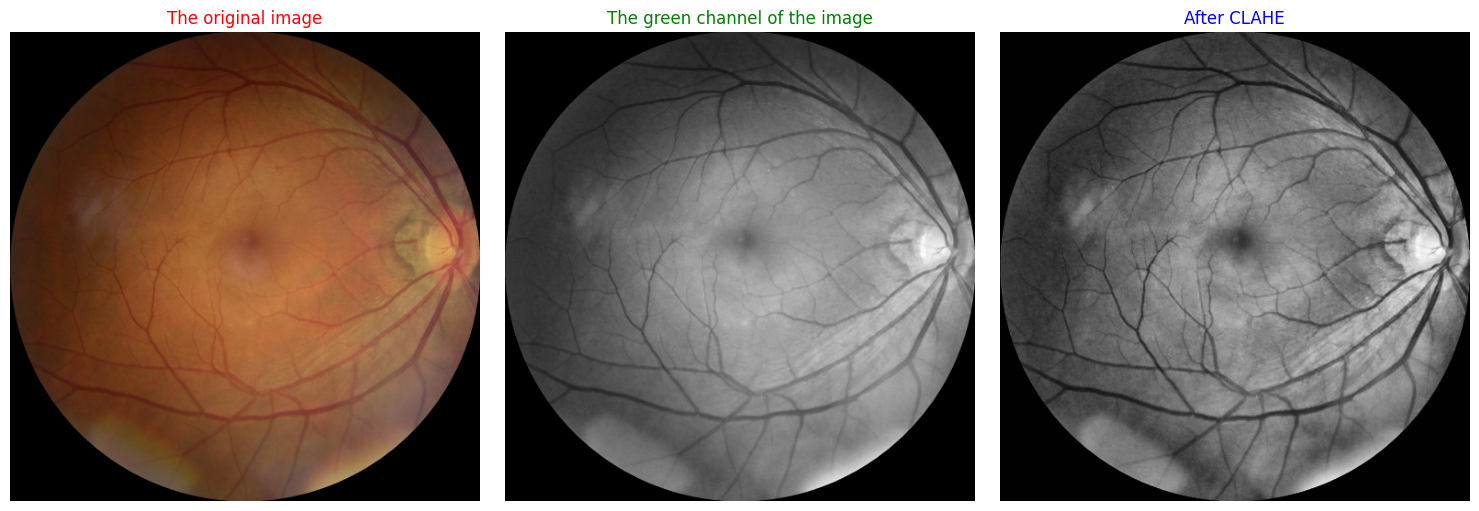

In [7]:
# Example Usage
example_class_dir = os.listdir(TRAIN_PATH)[0]  # Use the first class folder dynamically
example_image_path = os.path.join(TRAIN_PATH, example_class_dir, os.listdir(os.path.join(TRAIN_PATH, example_class_dir))[0])
print(f"Processing image: {example_image_path}")
display_example(example_image_path)

In [8]:
# Custom Dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.classes = os.listdir(root_dir)
        self.image_paths = []
        self.labels = []
        for label, cls in enumerate(self.classes):
            class_path = os.path.join(root_dir, cls)
            for image_name in os.listdir(class_path):
                self.image_paths.append(os.path.join(class_path, image_name))
                self.labels.append(label)
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = preprocess_image(image_path)
        image = torch.tensor(image, dtype=torch.float32).repeat(3, 1, 1)  # Convert to 3-channel
        return image, label

In [9]:
# Dataloaders
train_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = CustomDataset(TRAIN_PATH, transform=train_transform)
val_dataset = CustomDataset(VAL_PATH, transform=train_transform)
test_dataset = CustomDataset(TEST_PATH, transform=train_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define Model
model = models.vit_b_16(pretrained=True)
model.heads = nn.Sequential(
    nn.Linear(model.heads.head.in_features, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 2)
)
model = model.to(DEVICE)

# Display Model Structure
def print_model_structure(model):
    print("\nModel Structure:\n")
    print(model)

print_model_structure(model)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 194MB/s]



Model Structure:

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=Tr

In [10]:
# Training Loop
training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []

def train_model():
    model.train()
    for epoch in range(EPOCHS):
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train

        training_loss.append(train_loss)
        training_accuracy.append(train_acc)

        # Validation step
        model.eval()
        correct_val = 0
        total_val = 0
        val_running_loss = 0.0

        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(DEVICE), val_labels.to(DEVICE)
                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_labels)
                val_running_loss += val_loss.item()
                _, val_preds = torch.max(val_outputs, 1)
                correct_val += (val_preds == val_labels).sum().item()
                total_val += val_labels.size(0)

        val_loss = val_running_loss / len(val_loader)
        val_acc = correct_val / total_val

        validation_loss.append(val_loss)
        validation_accuracy.append(val_acc)

        print(f"Epoch [{epoch + 1}/{EPOCHS}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Evaluation Loop
def evaluate_model(loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

# Train and Evaluate
train_model()

Epoch [1/30], Train Loss: 0.5021, Train Acc: 0.7537, Val Loss: 0.4367, Val Acc: 0.8417
Epoch [2/30], Train Loss: 0.3671, Train Acc: 0.8399, Val Loss: 0.3028, Val Acc: 0.8815
Epoch [3/30], Train Loss: 0.3135, Train Acc: 0.8661, Val Loss: 0.2185, Val Acc: 0.9123
Epoch [4/30], Train Loss: 0.2681, Train Acc: 0.8869, Val Loss: 0.2122, Val Acc: 0.9222
Epoch [5/30], Train Loss: 0.2307, Train Acc: 0.9044, Val Loss: 0.1386, Val Acc: 0.9429
Epoch [6/30], Train Loss: 0.2028, Train Acc: 0.9159, Val Loss: 0.1402, Val Acc: 0.9528
Epoch [7/30], Train Loss: 0.1759, Train Acc: 0.9295, Val Loss: 0.1248, Val Acc: 0.9570
Epoch [8/30], Train Loss: 0.1496, Train Acc: 0.9413, Val Loss: 0.0933, Val Acc: 0.9702
Epoch [9/30], Train Loss: 0.1181, Train Acc: 0.9551, Val Loss: 0.1172, Val Acc: 0.9530
Epoch [10/30], Train Loss: 0.1107, Train Acc: 0.9559, Val Loss: 0.0634, Val Acc: 0.9772
Epoch [11/30], Train Loss: 0.1065, Train Acc: 0.9581, Val Loss: 0.1071, Val Acc: 0.9582
Epoch [12/30], Train Loss: 0.0842, Train 

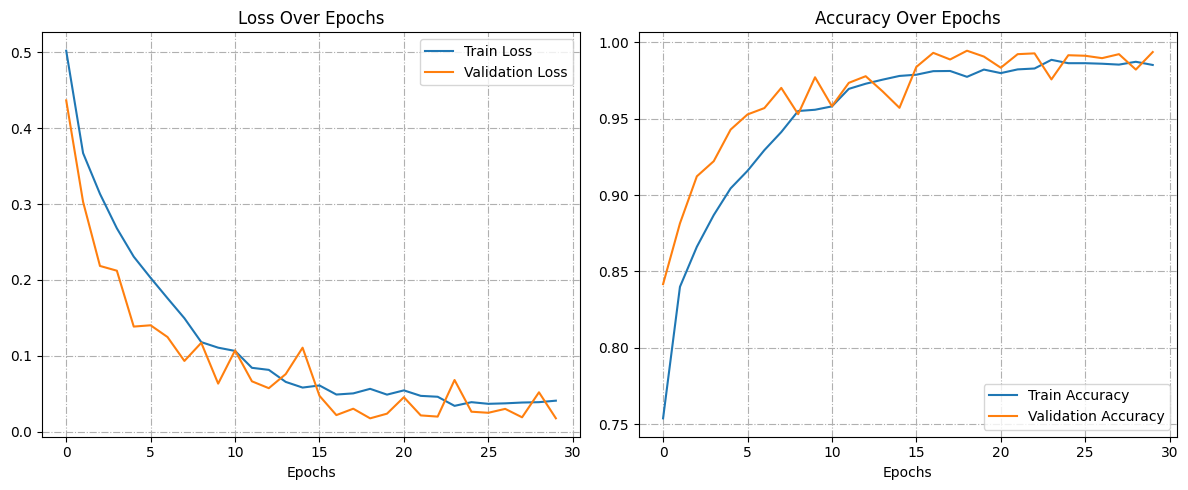

In [11]:
# Plot Training Results
fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=100)
# Loss Plot
axs[0].grid(linestyle='dashdot')
axs[0].plot(training_loss, label='Train Loss')
axs[0].plot(validation_loss, label='Validation Loss')
axs[0].set_xlabel('Epochs', fontsize=10)
axs[0].legend(fontsize=10)
axs[0].set_title('Loss Over Epochs')
# Accuracy Plot
axs[1].grid(linestyle='dashdot')
axs[1].plot(training_accuracy, label='Train Accuracy')
axs[1].plot(validation_accuracy, label='Validation Accuracy')
axs[1].set_xlabel('Epochs', fontsize=10)
axs[1].legend(fontsize=10)
axs[1].set_title('Accuracy Over Epochs')

plt.tight_layout()
plt.show()

In [12]:
print("Validation Results")
val_labels, val_preds = evaluate_model(val_loader)
print(classification_report(val_labels, val_preds, target_names=["No Glaucoma", "Glaucoma"]))

print("Test Results")
test_labels, test_preds = evaluate_model(test_loader)
print(classification_report(test_labels, test_preds, target_names=["No Glaucoma", "Glaucoma"]))

Validation Results
              precision    recall  f1-score   support

 No Glaucoma       1.00      0.99      0.99      3539
    Glaucoma       0.99      1.00      0.99      2208

    accuracy                           0.99      5747
   macro avg       0.99      0.99      0.99      5747
weighted avg       0.99      0.99      0.99      5747

Test Results
              precision    recall  f1-score   support

 No Glaucoma       1.00      0.99      0.99      1754
    Glaucoma       0.98      1.00      0.99      1120

    accuracy                           0.99      2874
   macro avg       0.99      0.99      0.99      2874
weighted avg       0.99      0.99      0.99      2874



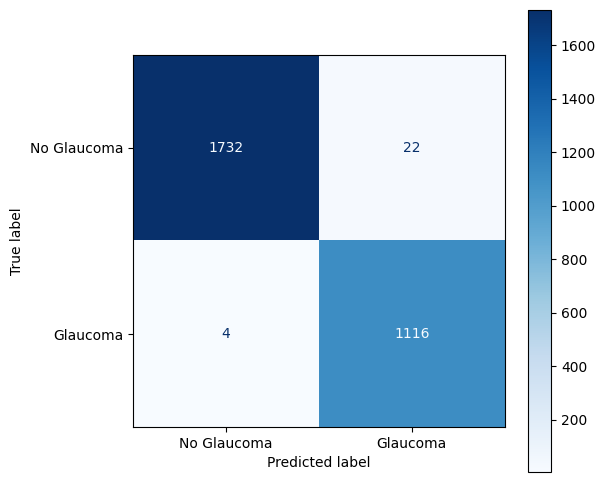

In [13]:
# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
cmd = ConfusionMatrixDisplay(cm, display_labels=["No Glaucoma", "Glaucoma"])

fig, ax = plt.subplots(figsize=(6, 6))
cmd.plot(ax=ax, cmap='Blues')
plt.show()

In [14]:
# Random Test Set Predictions
def random_test_sample_with_prediction(seed, test_loader, test_labels, test_preds):
    assert len(test_labels) == len(test_preds), "test_labels and test_preds must have the same length."
    np.random.seed(seed)
    indices = np.random.choice(len(test_labels), 5, replace=False)

    fig, axs = plt.subplots(1, 5, figsize=(15, 5), dpi=150)
    for i, idx in enumerate(indices):
        image, label = test_loader.dataset[idx]
        pred = test_preds[idx]

        image = image.numpy().transpose(1, 2, 0)
        image = np.clip(image, 0, 1)

        axs[i].imshow(image, cmap='gray')
        if pred == label:
            axs[i].set_title(f"True: {label}, Pred: {pred}", fontsize=8, color='green')
        else:
            axs[i].set_title(f"True: {label}, Pred: {pred}", fontsize=8, color='red')
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()


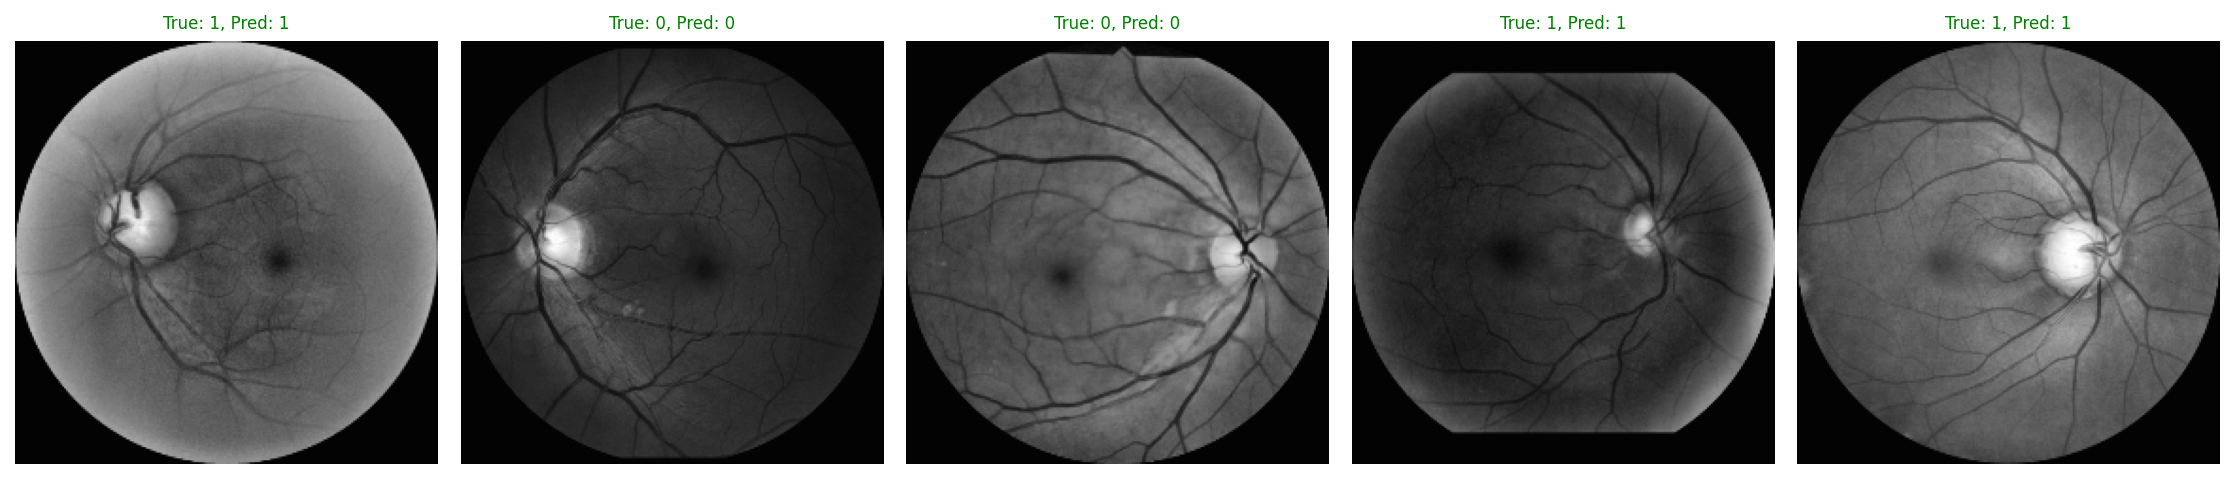

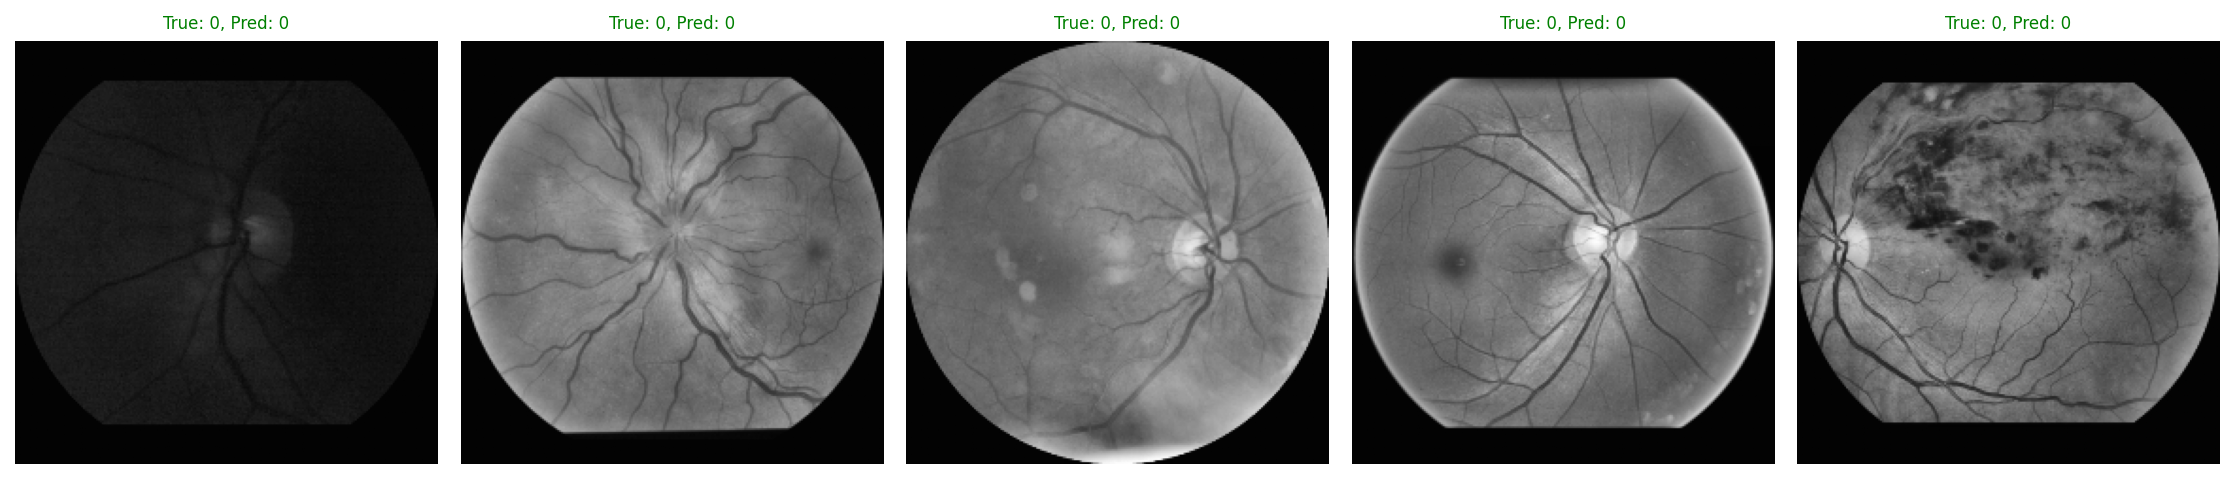

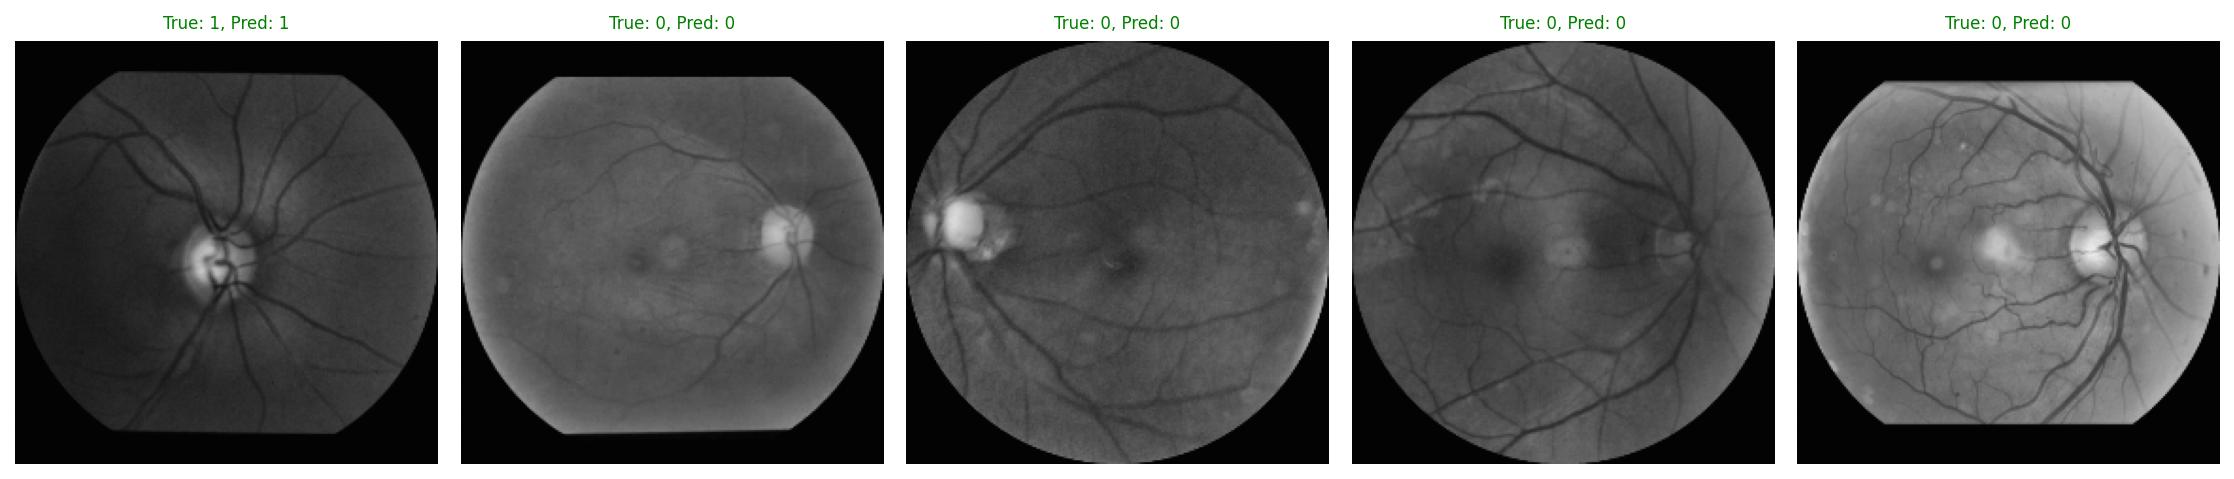

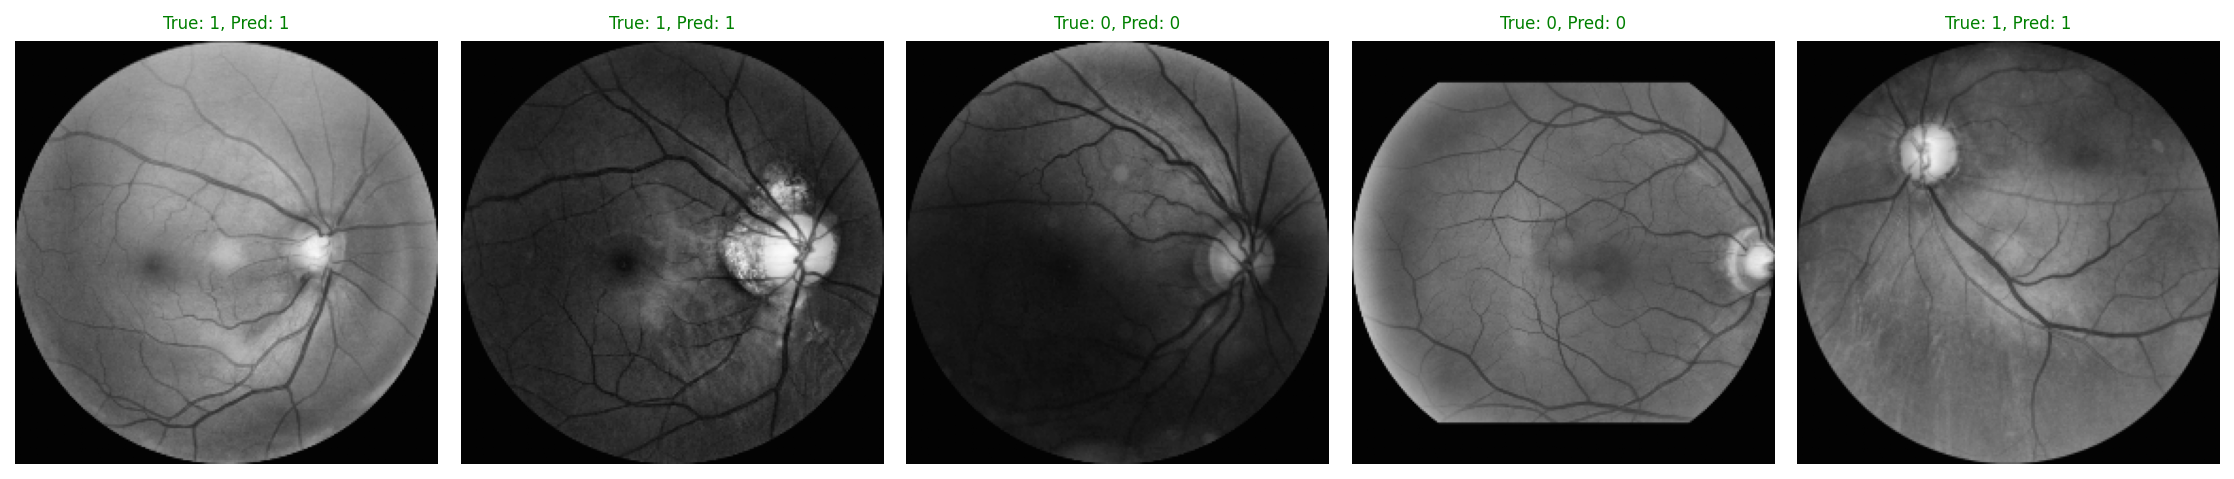

In [15]:
# Example Usage of Random Predictions
random_test_sample_with_prediction(seed=14, test_loader=test_loader, test_labels=test_labels, test_preds=test_preds)
random_test_sample_with_prediction(seed=32, test_loader=test_loader, test_labels=test_labels, test_preds=test_preds)
random_test_sample_with_prediction(seed=9, test_loader=test_loader, test_labels=test_labels, test_preds=test_preds)
random_test_sample_with_prediction(seed=407, test_loader=test_loader, test_labels=test_labels, test_preds=test_preds)
